### Optimized CPNS Prediction System

1. Code Structure & Organization
   - Implemented OOP approach with DataProcessor class for better maintainability
   - Separated data processing logic from model training
   - Modular functions for visualization and evaluation
   - Reduced code duplication through reusable components

2. Performance Improvements
   - Optimized data cleaning with vectorized operations
   - Improved outlier handling using numpy's clip function
   - Efficient feature scaling implementation
   - Streamlined model evaluation pipeline

3. Feature Engineering
   - Enhanced data validation with comprehensive checks
   - Improved SMOTE implementation for better balance
   - More robust feature importance analysis
   - Standardized scaling process

4. Visualization Enhancements
   - Consistent plotting interface
   - Improved readability of charts
   - Better organization of visual analytics
   - Standardized plot styling

5. Error Handling & Validation
   - Added data validation checks
   - Improved unrealistic value detection
   - Better duplicate handling
   - Enhanced missing value management

6. Memory Optimization
   - Reduced redundant data copies
   - Optimized DataFrame operations
   - Better memory management in loops
   - Efficient data transformation pipeline


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import drive
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)


class DataProcessor:
    """
    Manages structured data processing for CPNS predictions.
    Enhanced from previous version with separated preprocessing logic
    to improve maintainability and reusability.
    """

    def __init__(self, file_path: str):
        self.data = pd.read_excel(file_path)
        self.feature_columns = ["Umur", "Nilai IPK", "Nilai SKD", "Nilai SKB"]
        self.target_column = "Keterangan"
        self.label_encoder = LabelEncoder()

    def clean_data(self) -> None:
        """
        Efficient data cleaning:
        - Robust outlier handling using IQR method with separate handling for skewed data.
        - Automatic duplicate and missing value removal
        """

        # Handle outliers using IQR method, consider skewness
        for feature in self.feature_columns:
            Q1 = self.data[feature].quantile(0.25)
            Q3 = self.data[feature].quantile(0.75)
            IQR = Q3 - Q1

            # Adjust outlier bounds for skewed distributions
            skewness = self.data[feature].skew()
            if skewness > 1:  # Right-skewed
                upper_bound = Q3 + 1.5 * IQR
                lower_bound = self.data[feature].min()  # Avoid removing too many low values
            elif skewness < -1:  # Left-skewed
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = self.data[feature].max()  # Avoid removing too many high values
            else:  # Approximately symmetric
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

            self.data[feature] = np.clip(self.data[feature], lower_bound, upper_bound)

        self.data.drop_duplicates(inplace=True)
        self.data.dropna(inplace=True)

    def get_features_and_target(self):
        X = self.data[self.feature_columns]
        y = self.label_encoder.fit_transform(self.data[self.target_column])
        return X, y

    def print_statistics(self) -> None:
        print("Ringkasan Statistik:")
        print(self.data.describe())
        print("\nJumlah Missing Values:")
        print(self.data.isnull().sum())
        print("\nDistribusi Kelas:")
        print(self.data[self.target_column].value_counts())

    def validate_data(self) -> None:
        unrealistic_values = []
        for feature, min_val, max_val in [
            ("Umur", 17, 60),
            ("Nilai IPK", 0, 4),
            ("Nilai SKD", 0, 500),
            ("Nilai SKB", 0, 500),
        ]:
            unrealistic_data = self.data[
                (self.data[feature] < min_val) | (self.data[feature] > max_val)
            ][feature]
            if not unrealistic_data.empty:
                unrealistic_values.append(
                    pd.DataFrame(
                        {
                            "Feature": feature,
                            "Unrealistic Value": unrealistic_data.values,
                            "Index": unrealistic_data.index,
                        }
                    )
                )

        if unrealistic_values:
            print("\nUnrealistic values found:")
            print(pd.concat(unrealistic_values))
        else:
            print("\nNo unrealistic values found.")

        dups = len(self.data) - len(self.data.drop_duplicates())
        print(f"\nJumlah Data Duplikat: {dups}")

    def plot_box_plots(self) -> None:
        for feature in self.feature_columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=self.data, x=self.target_column, y=feature)
            plt.title(f"Box Plot of {feature}")
            plt.show()

        # After outlier handling
        for feature in self.feature_columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=self.data, x=self.target_column, y=feature)
            plt.title(f"Box Plot of {feature} (After Outlier Handling)")
            plt.show()

    def plot_correlation_matrix(self) -> None:
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.data[self.feature_columns].corr(), annot=True, cmap="coolwarm")
        plt.title("Correlation Matrix")
        plt.show()


def create_models():
    """
    Ensemble modeling with standard sklearn models:
    - SVM with probability enabled for ROC-AUC
    - Decision Tree with default parameters
    - Random Forest with 100 estimators
    - K-NN with k=5
    - Naïve Bayes
    """
    return {
        "SVM": SVC(kernel="linear", probability=True, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "K-NN": KNeighborsClassifier(n_neighbors=5),
        "Naïve Bayes": GaussianNB(),
    }


def evaluate_model(
    model, X_test, y_test, model_name, label_encoder, feature_columns, plot=True
):
    """
    Comprehensive model evaluation:
    - Multi-class ROC-AUC scoring
    - Detailed performance visualization
    - Feature importance analysis
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    print(f"\n{model_name} Results:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    roc_auc = roc_auc_score(pd.get_dummies(y_test), y_pred_proba, multi_class="ovr")
    print(f"ROC AUC Score: {roc_auc:.3f}")

    if plot:
        plot_confusion_matrices(y_test, y_pred, label_encoder.classes_, model_name)
        plot_roc_curves(y_test, y_pred_proba, label_encoder.classes_, model_name)
        if hasattr(model, "feature_importances_"):
            plot_feature_importance(model, feature_columns, model_name)


def plot_distributions(data: pd.DataFrame, features: list, target: str) -> None:
    """Match original style of distribution plots"""
    for feature in features:
        plt.figure(figsize=(8, 6))
        sns.histplot(data=data, x=feature, hue=target, kde=True)
        plt.title(f"Distribution of {feature}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


def plot_confusion_matrices(y_true, y_pred, labels, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,  # Match original style
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.xticks(rotation=45, ha="right")  # Match original rotation
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def plot_roc_curves(y_test, y_pred_proba, labels, model_name):
    plt.figure(figsize=(10, 8))
    y_test_bin = pd.get_dummies(y_test)

    fpr, tpr, _ = roc_curve(y_test_bin.values.ravel(), y_pred_proba.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        label=f"{model_name} (AUC = {roc_auc:.2f})",
        linestyle="-",
        linewidth=2,
    )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Tingkat Positif Palsu (False Positive Rate)")
    plt.ylabel("Tingkat Positif Benar (True Positive Rate)")
    plt.title("Kurva Karakteristik Operasi Penerima (ROC)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


def plot_feature_importance(model, feature_names, model_name):
    importances = model.feature_importances_
    importance_df = pd.DataFrame(
        {"Feature": feature_names, "Importance": importances}
    ).sort_values(
        by="Importance", ascending=True
    )  # Changed to match original

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"])
    plt.title(f"{model_name} - Feature Importance")
    plt.xlabel("Importance")
    plt.grid(True, axis="x")
    plt.tight_layout()
    plt.show()

In [2]:
# drive.mount('/content/drive')

# processor = DataProcessor(
#     "/content/drive/MyDrive/Colab Notebooks/LAMPIRAN I - Ringkasan Hasil Integrasi SKD dan SKB_Data Olahan_v2.xlsx"
# )
processor = DataProcessor(
    "LAMPIRAN I - Ringkasan Hasil Integrasi SKD dan SKB_Data Olahan_v2.xlsx"
)

In [3]:
# Print initial statistics
print("Ringkasan Statistik:")
print(processor.data)
print("\nJumlah Missing Values:")
print(processor.data.isnull().sum())

Ringkasan Statistik:
      No         No Peserta                       Nama Tanggal Lahir  Umur  \
0      1  24300520110001700             M RAFIF TAJATI    2000-05-14    24   
1      2  24300520110002300           DANIEL SEPTIANUS    2002-09-25    22   
2      3  24300520110002500    MUHAMMAD JUNDI AS SALIM    2002-02-06    22   
3      4  24300520110007300     AUDRE AUGUSTA BATUBARA    1998-08-08    26   
4      5  24300520110008000   DANIEL HASIANTO HENDARTO    1998-05-13    26   
..   ...                ...                        ...           ...   ...   
608  609  24300520120013483  SEPTARINDA BELLA PRAMESTI    1998-09-05    26   
609  610  24300520120013507        NABILA ASYSYIFA NUR    2000-01-04    25   
610  611  24300520120013552             ANGGITA SALMIA    1999-09-26    25   
611  612  24300520120013567              ANISA YULIANI    1997-07-19    27   
612  613  24300520120013945       INDAH HANIF MAHARANI    1998-12-13    26   

     Nilai IPK  Nilai SKD  Nilai SKB Keter

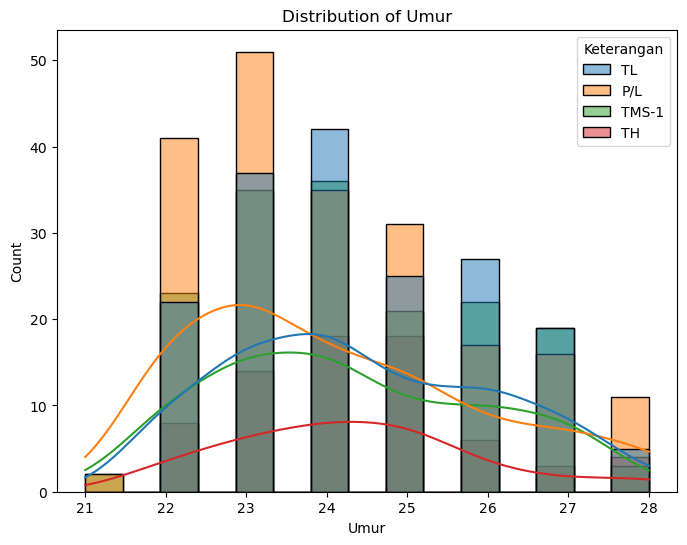

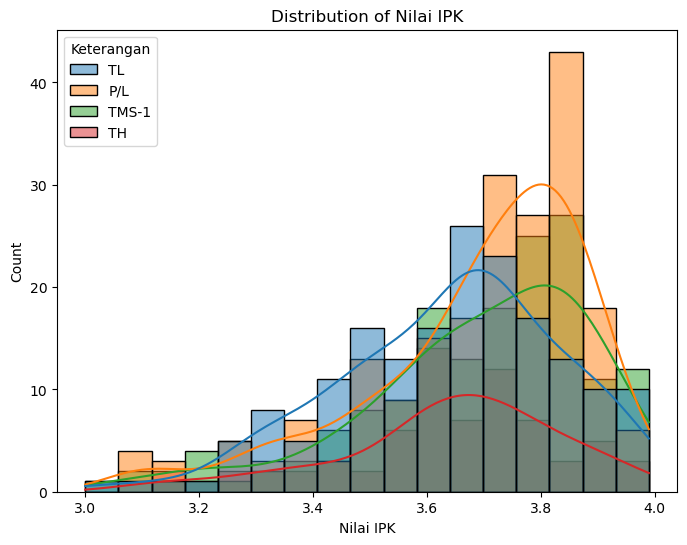

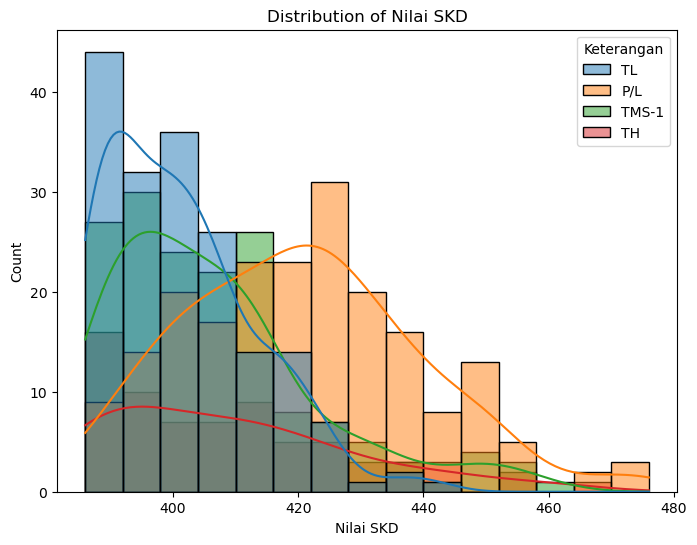

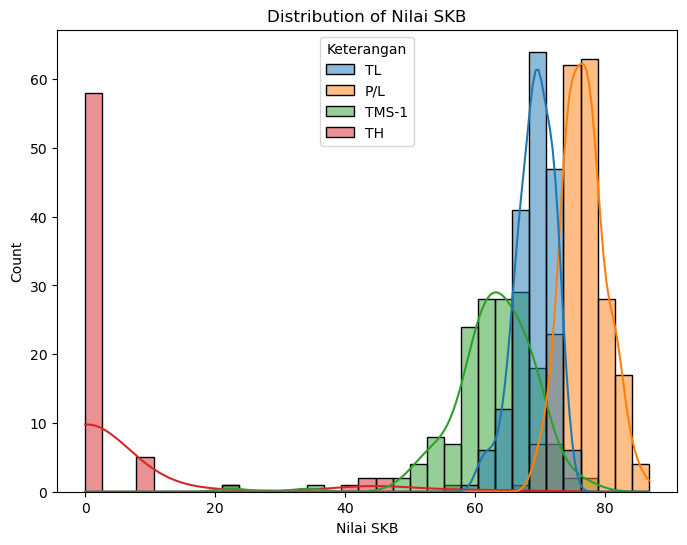

In [4]:
# Initial visualizations - Distribution plots
for feature in processor.feature_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=processor.data, x=feature, hue=processor.target_column, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.show()

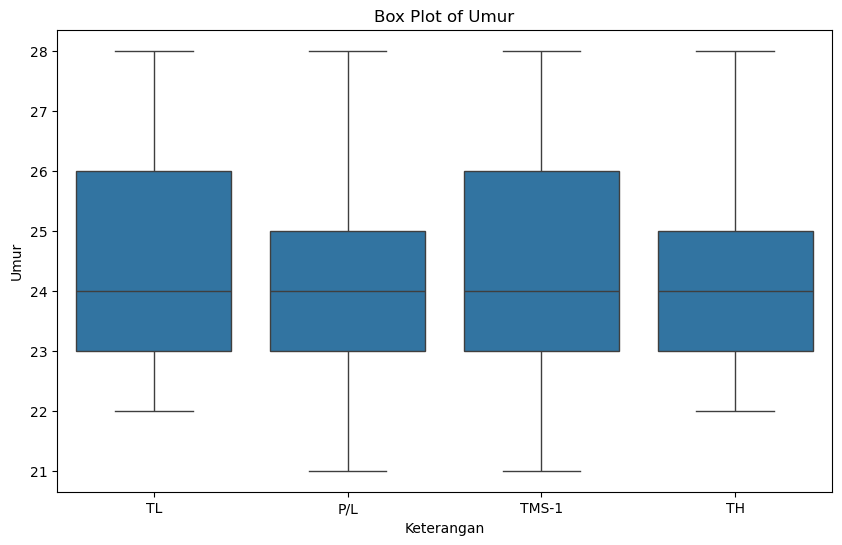

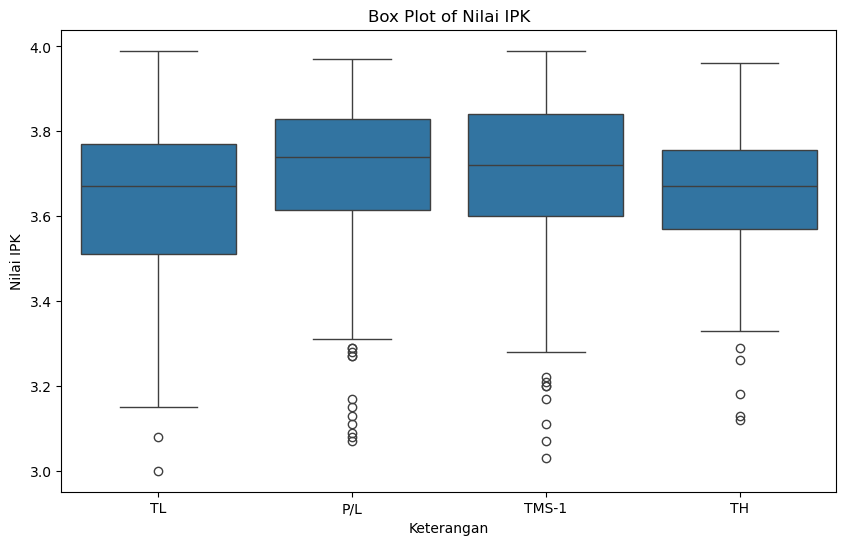

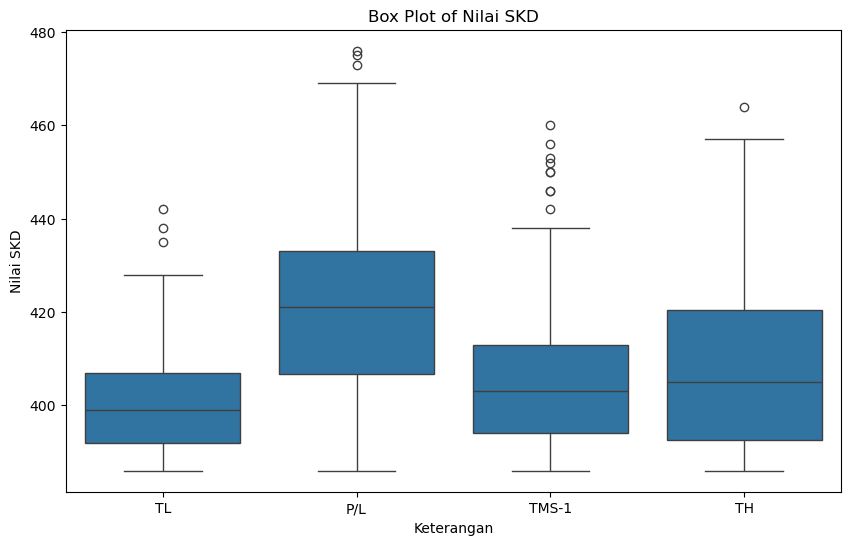

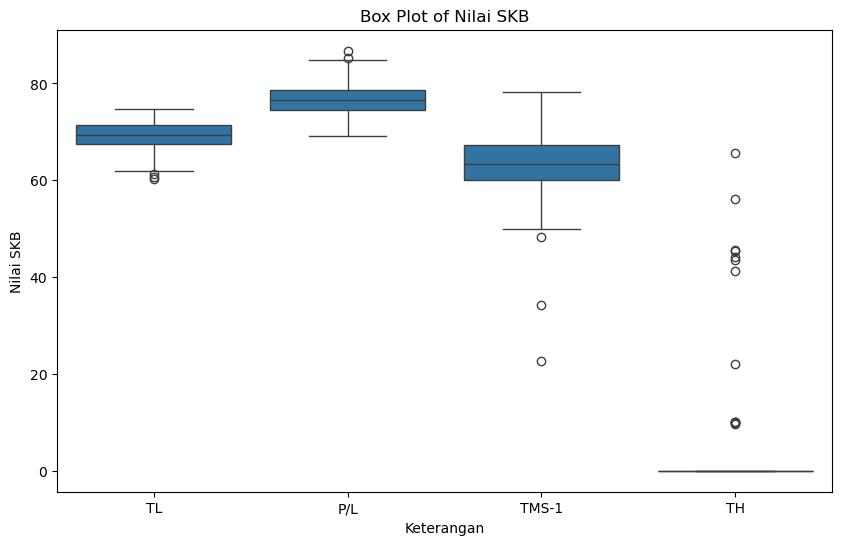

In [5]:
# Initial box plots before outlier handling
for feature in processor.feature_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=processor.data, x=processor.target_column, y=feature)
    plt.title(f"Box Plot of {feature}")
    plt.show()

In [6]:
# Data cleaning
processor.clean_data()

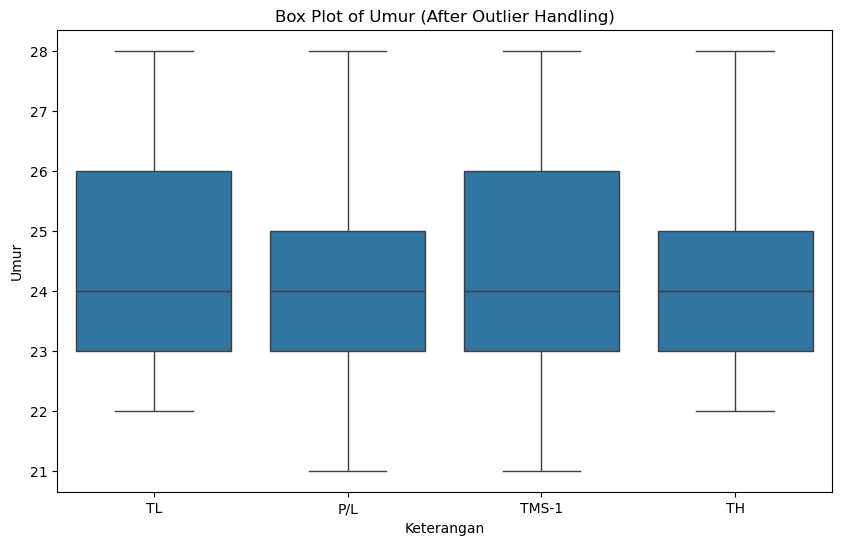

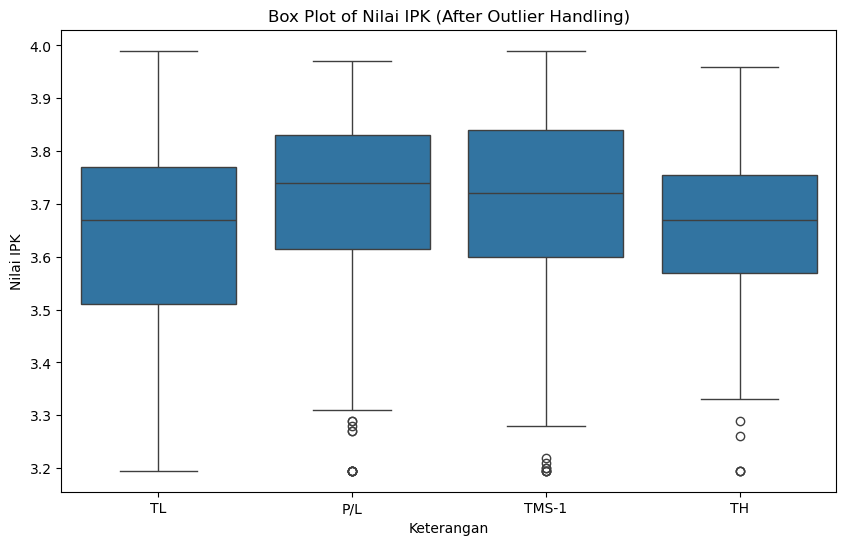

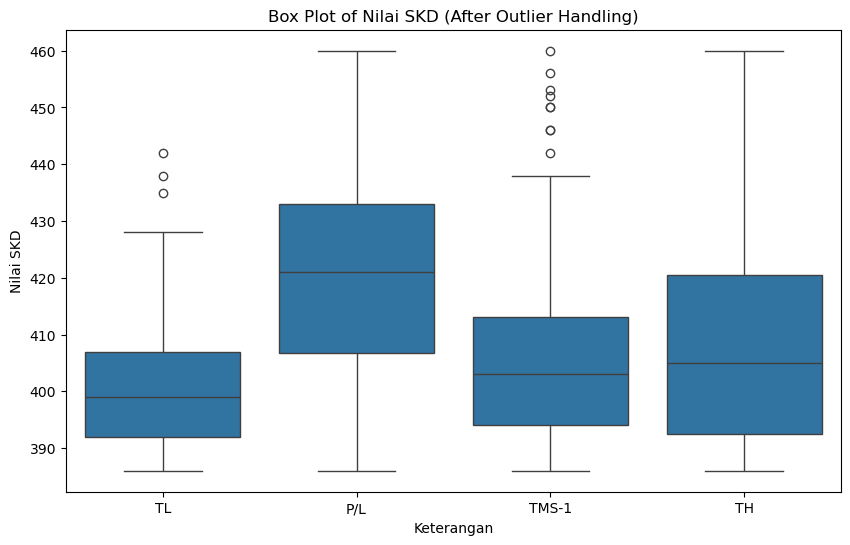

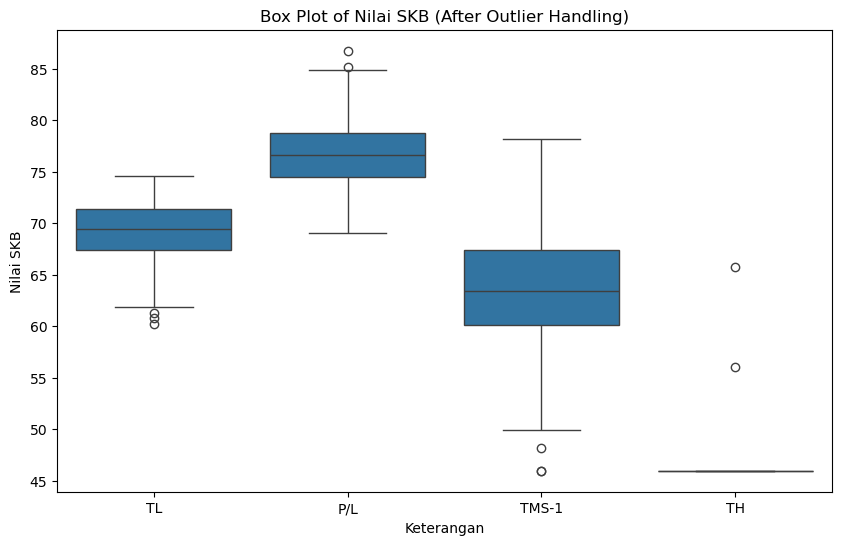

In [7]:
# Box plots after outlier handling
for feature in processor.feature_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=processor.data, x=processor.target_column, y=feature)
    plt.title(f"Box Plot of {feature} (After Outlier Handling)")
    plt.show()

In [8]:
# Show class distribution
class_counts = processor.data[processor.target_column].value_counts()
print("\nClass Distribution:")
print(class_counts)


Class Distribution:
Keterangan
P/L      204
TL       177
TMS-1    161
TH        71
Name: count, dtype: int64


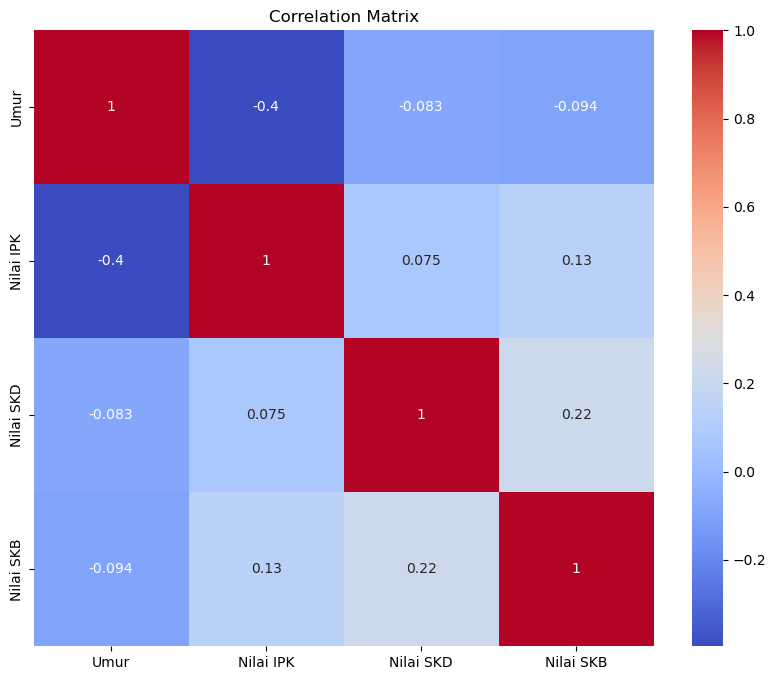

In [9]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    processor.data[processor.feature_columns].corr(), annot=True, cmap="coolwarm"
)
plt.title("Correlation Matrix")
plt.show()

In [10]:
# Data validation
processor.validate_data()


No unrealistic values found.

Jumlah Data Duplikat: 0


In [11]:
# Get features and target
X, y = processor.get_features_and_target()

In [12]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [13]:
X_train_main, X_test_final, y_train_main, y_test_final = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
# Inisialisasi KFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_train_main, y_train_main):
    X_train, X_test = X_train_main.iloc[train_index], X_train_main.iloc[test_index]
    y_train, y_test = y_train_main[train_index], y_train_main[test_index]

In [15]:
print(X_test)
print(X_train)

         Umur  Nilai IPK  Nilai SKD  Nilai SKB
412  1.607726  -0.067995  -0.261873   0.657835
237  1.607726  -1.691244   1.074471   1.112128
268 -1.335930   0.717448  -0.540278  -0.328154
440 -0.158468   0.874537   0.406299  -1.057722
362 -0.747199   0.979263   0.796066   0.942934
..        ...        ...        ...        ...
191  1.607726   0.036731  -0.874365  -0.854193
427 -0.747199  -0.172721  -0.317554   0.149062
124 -1.335930   0.612723   0.406299   0.898477
475 -0.747199   1.188714   0.294937  -0.109045
50  -0.747199   0.455634   0.406299   0.593531

[98 rows x 4 columns]
         Umur  Nilai IPK  Nilai SKD  Nilai SKB
376 -0.158468   0.246182  -0.484597   0.451329
374  2.196457  -1.062890  -0.707322   0.681948
587  0.430264  -1.272341   0.294937   0.447062
171  0.430264  -1.010527  -0.094830  -0.940527
583 -0.158468  -0.486898  -0.540278   0.971414
..        ...        ...        ...        ...
555  1.607726   0.769811   0.127894  -0.783737
137 -1.335930   0.193820  -0.930046  

In [16]:
# Terapkan SMOTE untuk oversampling data pelatihan
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Dapatkan label kelas unik
unique_labels = np.unique(y_train)

# Cetak distribusi kelas sebelum dan sesudah SMOTE
print("\nClass distribution before SMOTE:")
for label in unique_labels:
    count = np.sum(y_train == label)
    print(f"Label {processor.label_encoder.inverse_transform([label])[0]}: {count}")

print("\nClass distribution after SMOTE:")
for label in unique_labels:
    count = np.sum(y_train_resampled == label)
    print(f"Label {processor.label_encoder.inverse_transform([label])[0]}: {count}")


Class distribution before SMOTE:
Label P/L: 131
Label TH: 45
Label TL: 113
Label TMS-1: 103

Class distribution after SMOTE:
Label P/L: 131
Label TH: 131
Label TL: 131
Label TMS-1: 131


In [17]:
# Create and train models
models = create_models()
trained_models = {}


Training SVM...

SVM Classification Report:
              precision    recall  f1-score   support

         P/L       1.00      1.00      1.00        32
          TH       1.00      1.00      1.00        12
          TL       0.71      0.86      0.77        28
       TMS-1       0.80      0.62      0.70        26

    accuracy                           0.86        98
   macro avg       0.88      0.87      0.87        98
weighted avg       0.86      0.86      0.85        98



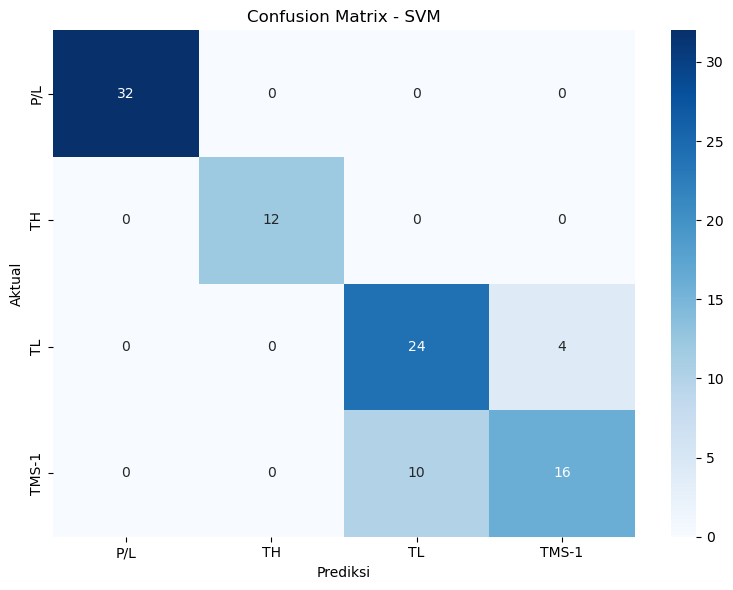


Training Decision Tree...

Decision Tree Classification Report:
              precision    recall  f1-score   support

         P/L       1.00      0.97      0.98        32
          TH       1.00      0.92      0.96        12
          TL       0.69      0.79      0.73        28
       TMS-1       0.71      0.65      0.68        26

    accuracy                           0.83        98
   macro avg       0.85      0.83      0.84        98
weighted avg       0.83      0.83      0.83        98



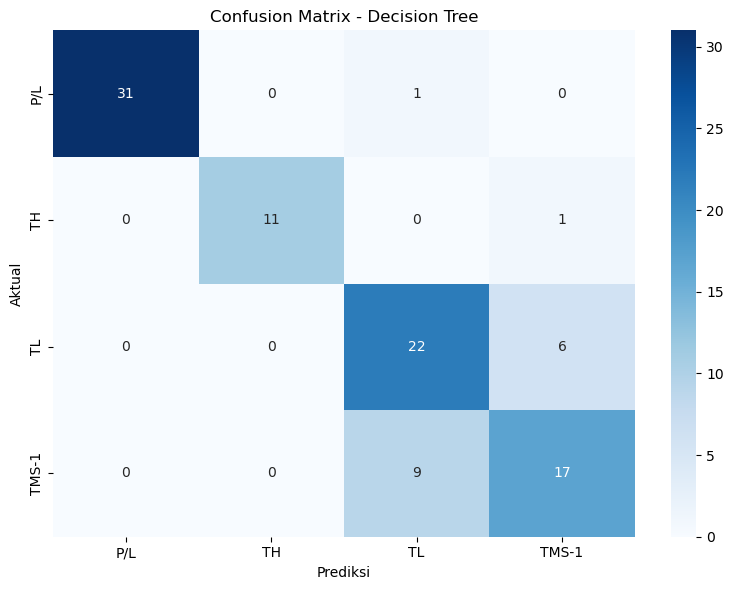


Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

         P/L       1.00      0.97      0.98        32
          TH       1.00      1.00      1.00        12
          TL       0.73      0.86      0.79        28
       TMS-1       0.77      0.65      0.71        26

    accuracy                           0.86        98
   macro avg       0.88      0.87      0.87        98
weighted avg       0.86      0.86      0.86        98



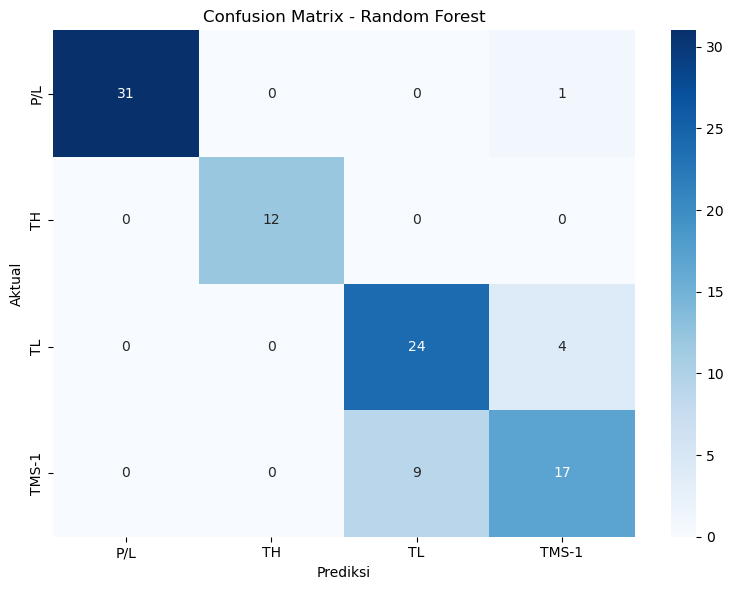


Training K-NN...

K-NN Classification Report:
              precision    recall  f1-score   support

         P/L       0.94      0.91      0.92        32
          TH       0.92      1.00      0.96        12
          TL       0.61      0.61      0.61        28
       TMS-1       0.58      0.58      0.58        26

    accuracy                           0.74        98
   macro avg       0.76      0.77      0.77        98
weighted avg       0.75      0.74      0.74        98



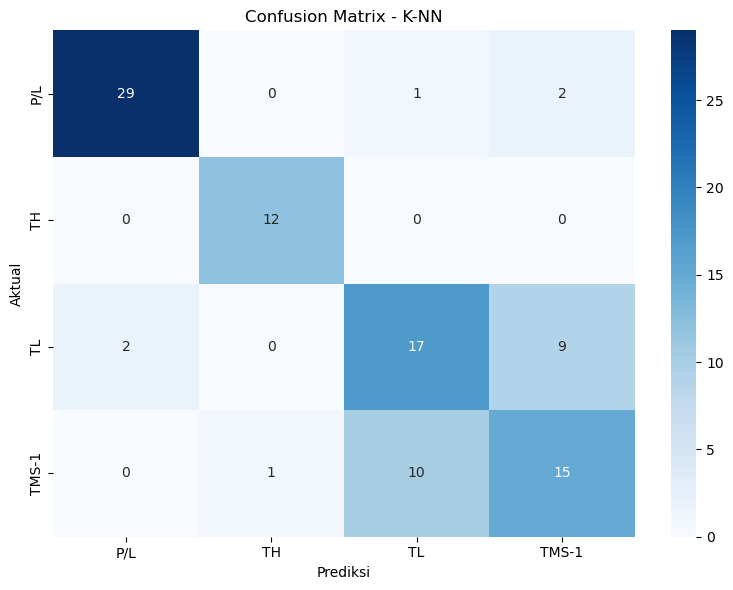


Training Naïve Bayes...

Naïve Bayes Classification Report:
              precision    recall  f1-score   support

         P/L       1.00      1.00      1.00        32
          TH       1.00      1.00      1.00        12
          TL       0.72      0.93      0.81        28
       TMS-1       0.89      0.62      0.73        26

    accuracy                           0.88        98
   macro avg       0.90      0.89      0.88        98
weighted avg       0.89      0.88      0.87        98



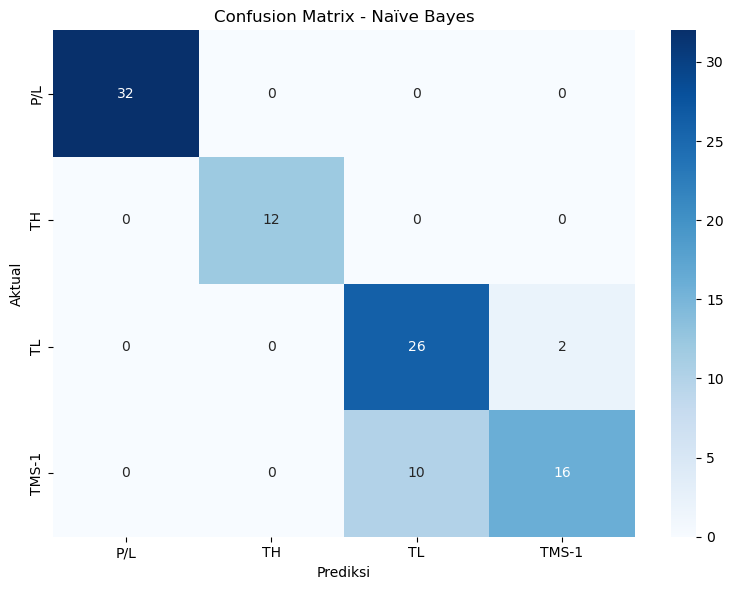

In [18]:
# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_resampled, y_train_resampled)
    trained_models[model_name] = model

    # Print classification report
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=processor.label_encoder.classes_)) # Menambahkan target_names

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=processor.label_encoder.classes_,
        yticklabels=processor.label_encoder.classes_,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.tight_layout()
    plt.show()

In [24]:
import joblib
import os

# Create models folder if it doesn't exist
if not os.path.exists("models"):
    os.makedirs("models")
    print("Created 'models' folder.")

models = create_models()
trained_models = {}
accuracy_scores = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    
    # Calculate accuracy score
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = accuracy
    
    # Save model to models folder
    model_filename = f"models/{name.replace(' ', '_').lower()}_model.joblib"
    joblib.dump(model, model_filename)
    print(f"Saved {name} model with accuracy: {accuracy}")
    
    # Store trained model for later use
    trained_models[name] = model

# Save label encoder to models folder
joblib.dump(processor.label_encoder, "models/label_encoder.joblib")
print("Saved LabelEncoder.")

# Save accuracy scores to a text file
with open("models/accuracy_scores.txt", "w") as f:
    f.write("Model Accuracy Scores:\n")
    f.write("=" * 30 + "\n")
    for name, accuracy in accuracy_scores.items():
        f.write(f"{name}: {accuracy}\n")
print("Saved accuracy scores to models/accuracy_scores.txt")

# Display accuracy scores
print("\nModel Accuracy Scores:")
print("=" * 30)
for name, accuracy in accuracy_scores.items():
    print(f"{name}: {accuracy}") 

Training SVM...
Saved SVM model with accuracy: 0.8571428571428571
Training Decision Tree...
Saved Decision Tree model with accuracy: 0.826530612244898
Training Random Forest...
Saved Random Forest model with accuracy: 0.8571428571428571
Training K-NN...
Saved K-NN model with accuracy: 0.7448979591836735
Training Naïve Bayes...
Saved Naïve Bayes model with accuracy: 0.8775510204081632
Saved LabelEncoder.
Saved accuracy scores to models/accuracy_scores.txt

Model Accuracy Scores:
SVM: 0.8571428571428571
Decision Tree: 0.826530612244898
Random Forest: 0.8571428571428571
K-NN: 0.7448979591836735
Naïve Bayes: 0.8775510204081632


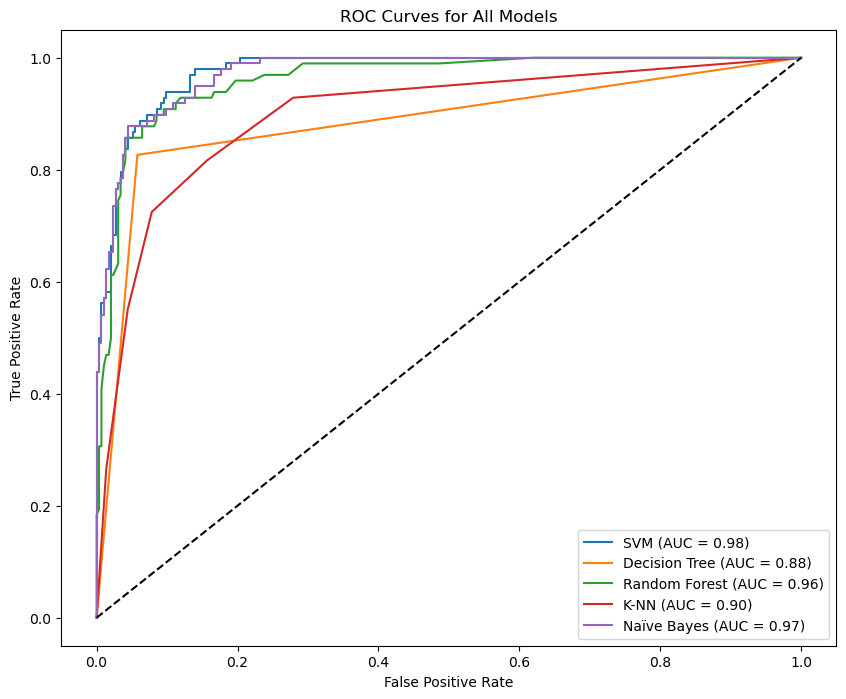

In [19]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for model_name, model in trained_models.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
        y_test_bin = pd.get_dummies(y_test)

        # Calculate micro-average ROC curve
        fpr, tpr, _ = roc_curve(y_test_bin.values.ravel(), y_pred_proba.ravel())
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.show()

best_model_name = max(
    trained_models,
    key=lambda model_name: roc_auc_score(
        y_test,
        trained_models[model_name].predict_proba(X_test)
        if trained_models[model_name].predict_proba(X_test).ndim > 1
        else trained_models[model_name].predict_proba(X_test).reshape(-1, 1),  # Reshape for 1D arrays
        multi_class="ovr",
    ),
)


Feature Importance untuk SVM:
     feature  importance
3  Nilai SKB    1.254985
2  Nilai SKD    0.260405
1  Nilai IPK    0.020341
0       Umur    0.016257


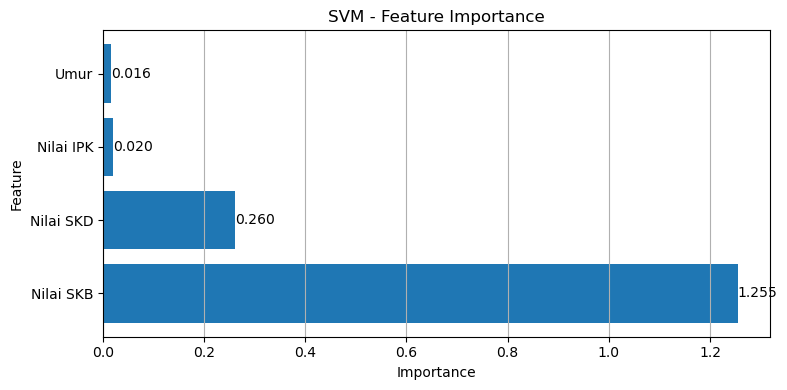


Feature Importance untuk Decision Tree:
     feature  importance
3  Nilai SKB    0.809882
2  Nilai SKD    0.090067
1  Nilai IPK    0.069755
0       Umur    0.030297


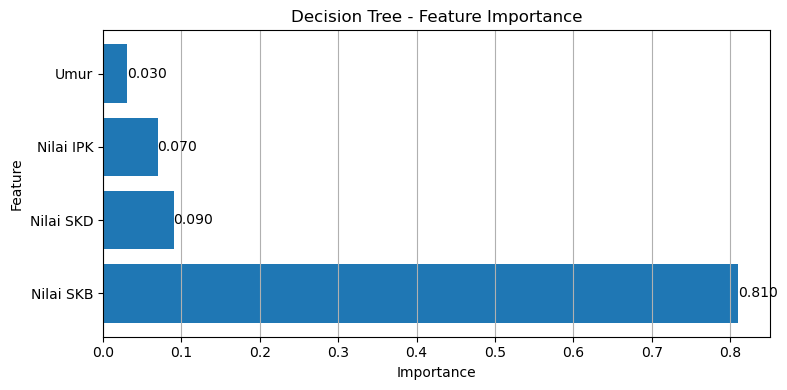


Feature Importance untuk Random Forest:
     feature  importance
3  Nilai SKB    0.727926
2  Nilai SKD    0.125023
1  Nilai IPK    0.096310
0       Umur    0.050740


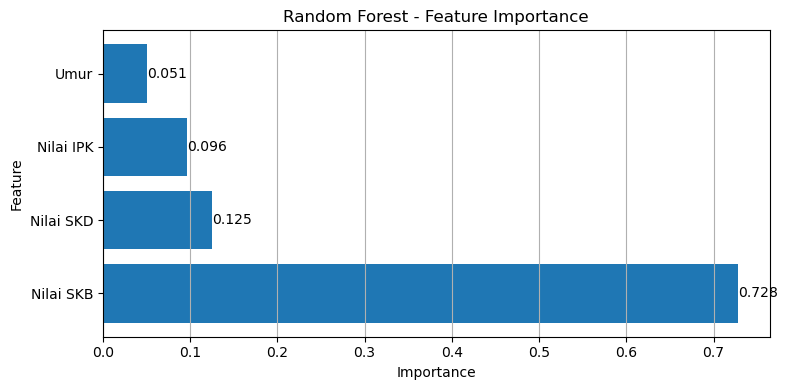

In [20]:
for model_name, model in trained_models.items():
    if model_name == "SVM":
        # Untuk Linear SVM
        importances = np.abs(model.coef_[0])
        feature_importances = pd.DataFrame({'feature': processor.feature_columns, 'importance': importances})
    elif model_name in ["Decision Tree", "Random Forest"]:
        # Untuk Decision Tree dan Random Forest
        importances = model.feature_importances_
        feature_importances = pd.DataFrame({'feature': processor.feature_columns, 'importance': importances})
    else:
        # Model lain yang tidak memiliki feature_importances_ akan dilewati
        continue

    feature_importances = feature_importances.sort_values('importance', ascending=False)

    print(f"\nFeature Importance untuk {model_name}:")
    print(feature_importances)

    # Visualisasi Feature Importance
    plt.figure(figsize=(8, 4))
    bars = plt.barh(feature_importances['feature'], feature_importances['importance'])
    plt.title(f"{model_name} - Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.grid(axis='x')

    # Menambahkan label value
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                 f'{width:.3f}', ha='left', va='center')

    plt.tight_layout()
    plt.show()